In [ ]:
# =====================================
# 1. Importing Libraries
# =====================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.inspection import permutation_importance

In [ ]:
# =====================================
# 2. Read, Clean and Preprocess Data
# =====================================

# Read file
df = pd.read_csv("economic_data.csv")

# Drop unnecessary columns
df = df.drop(columns=["Country Name", "Country Code", "Series Code"])

# Identify year columns
year_cols = [col for col in df.columns if len(col) >= 4 and col[:4].isdigit()]

# Melt the dataset to long format
df_long = df.melt(
    id_vars=['Series Name'],  # now we only have 'Series Name' as id variable
    value_vars=year_cols,
    var_name='Year',
    value_name='Value'
)

# Extract just the year as an integer
df_long['Year'] = df_long['Year'].apply(lambda x: x.split()[0])  # "2001" from "2001 [YR2001]"
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')

# Pivot Series Name to columns
df_pivot = df_long.pivot_table(
    index='Year',
    columns='Series Name',
    values='Value'
).reset_index()

# Sort by year
df_pivot.columns.name = None

# Reset the index so Year becomes a column
df_pivot = df_pivot.reset_index(drop=True)

# Drop rows with missing values
df_pivot = df_pivot.dropna()

In [ ]:
# =====================================
# 3. Identify Variables
# =====================================

# Target Variable
target_col = "GDP growth (annual %)"

# Independent Variables
predictors = [
    "Unemployment, total (% of total labor force) (national estimate)",
    "Imports of goods and services (% of GDP)",
    "Foreign direct investment, net outflows (% of GDP)",
    "Domestic credit to private sector (% of GDP)",
    "Population growth (annual %)",
    "Inflation, consumer prices (annual %)",
    "Real interest rate (%)",
    "General government final consumption expenditure (% of GDP)"
]

X = df_pivot[predictors]
y = df_pivot[target_col]

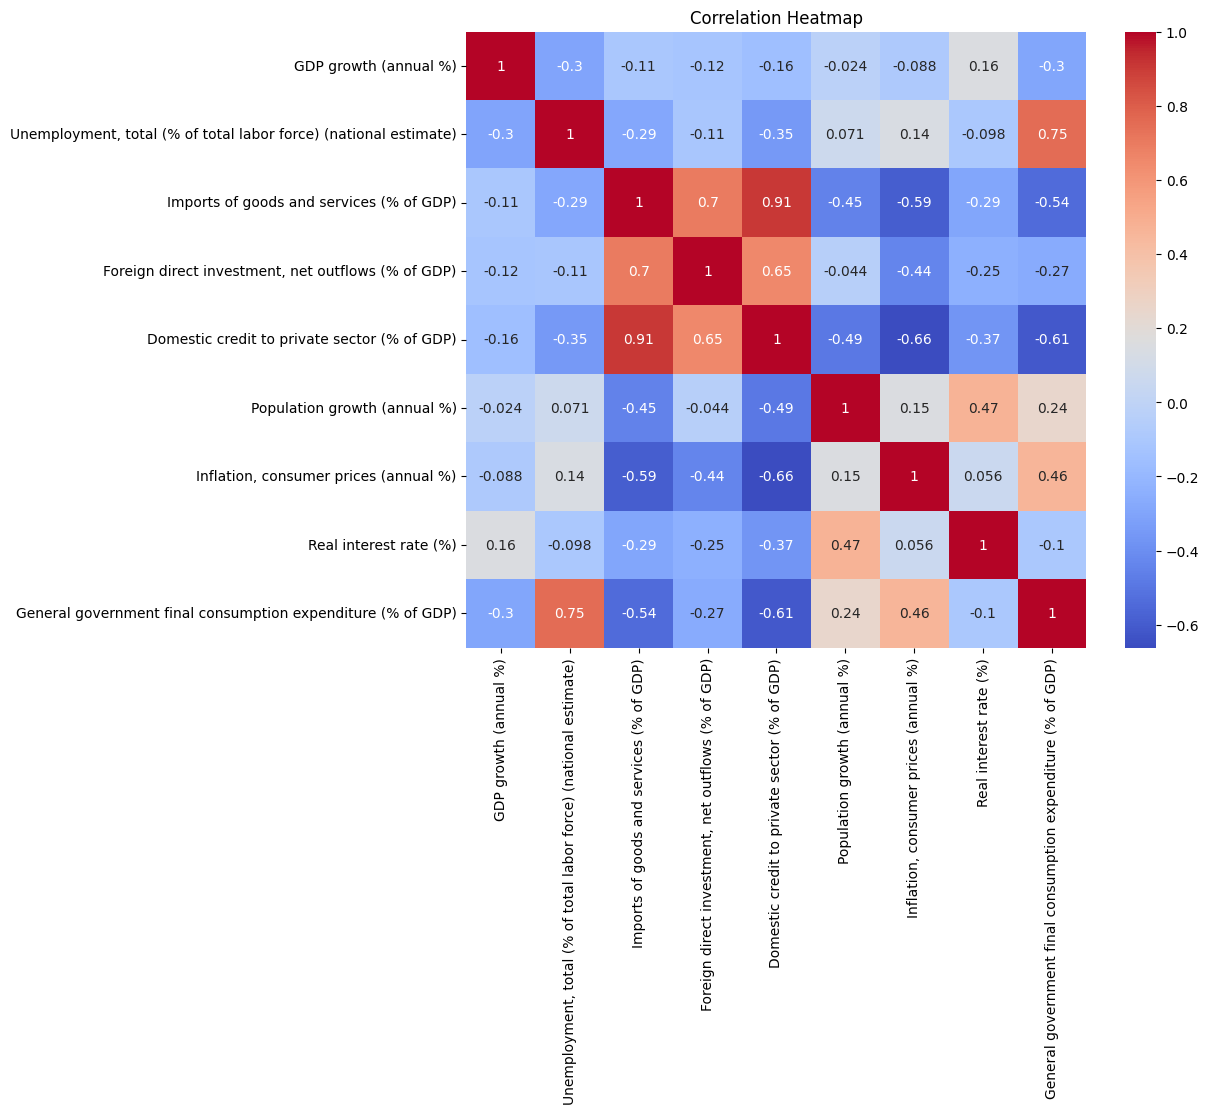

In [ ]:
# =====================================
# 4. Exploratory Data Analysis
# =====================================

# Correlation heatmap to explore relationships
plt.figure(figsize=(10,8))
sns.heatmap(df_pivot[[target_col] + predictors].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# =====================================
# 5. Modeling
# =====================================

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model Training
mlp1 = MLPRegressor(hidden_layer_sizes=(512, 256), max_iter=3000, random_state=42)
mlp2 = MLPRegressor(hidden_layer_sizes=(256, 128, 64), max_iter=3000, random_state=42)

stack = StackingRegressor(estimators=[('mlp1', mlp1), ('mlp2', mlp2)], final_estimator=MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=3000, random_state=42))
stack.fit(X_train, y_train)

StackingRegressor(estimators=[('mlp1',
                               MLPRegressor(hidden_layer_sizes=(512, 256),
                                            max_iter=3000, random_state=42)),
                              ('mlp2',
                               MLPRegressor(hidden_layer_sizes=(256, 128, 64),
                                            max_iter=3000, random_state=42))],
                  final_estimator=MLPRegressor(hidden_layer_sizes=(128, 64),
                                               max_iter=3000, random_state=42))

In [ ]:
# =====================================
# 6. Evaluation
# =====================================

y_pred = stack.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Model Performance:")
print("R² Score:", r2)
print("MSE:", mse)

Model Performance:
R² Score: 0.7449730824418855
MSE: 0.4934220172619173


<ipython-input-8-86ce1af85725>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y, label='Actual', shade=True)
<ipython-input-8-86ce1af85725>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_all_pred, label='Predicted', shade=True)


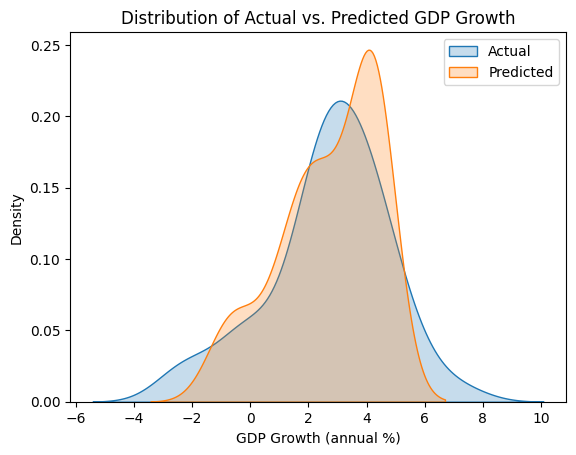

<ipython-input-8-86ce1af85725>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')


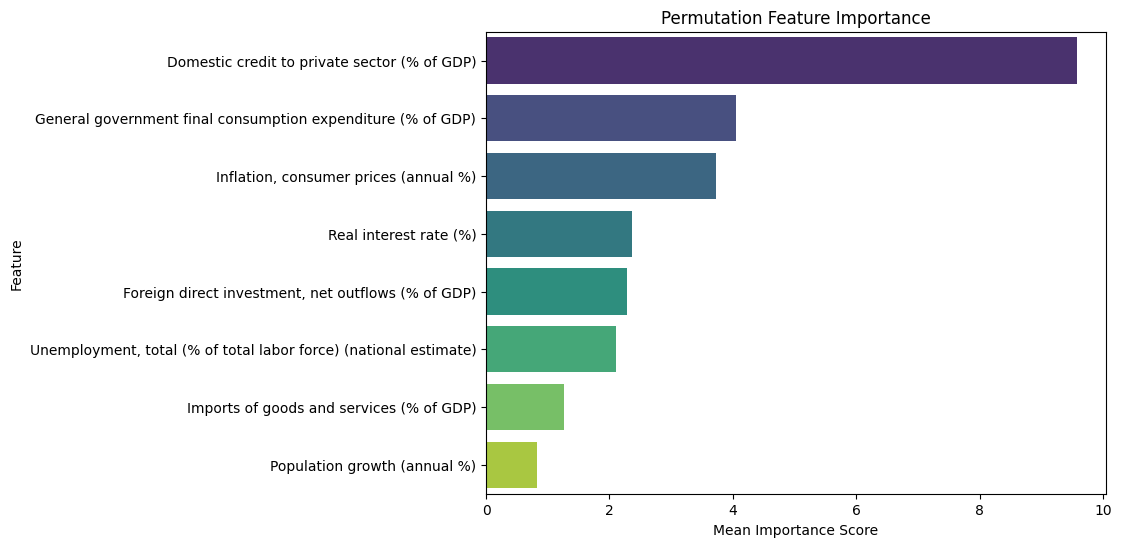

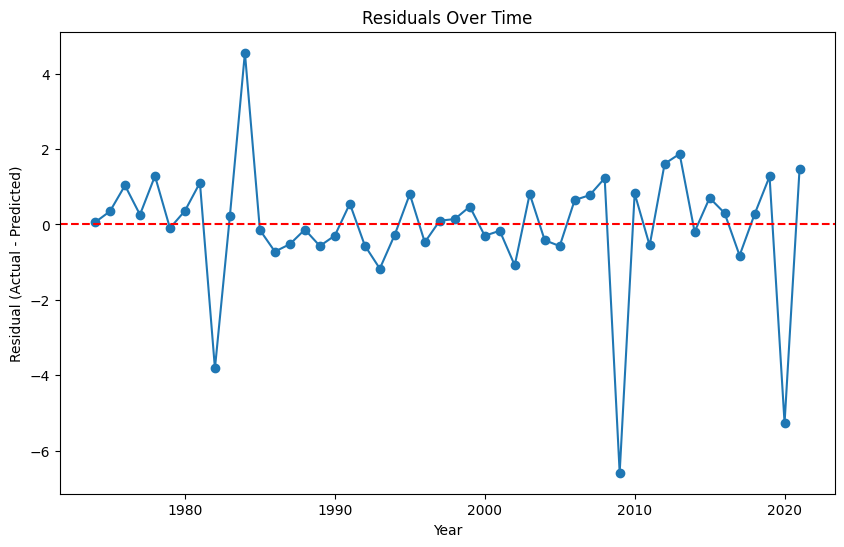

In [ ]:
# =====================================
# 7. Visualization
# =====================================

years = df_pivot['Year']
y_all_pred = stack.predict(X_scaled)
gdp = df_pivot['GDP growth (annual %)']

# Actual vs. Predicted Distribution Comparisons
sns.kdeplot(y, label='Actual', shade=True)
sns.kdeplot(y_all_pred, label='Predicted', shade=True)
plt.title('Distribution of Actual vs. Predicted GDP Growth')
plt.xlabel('GDP Growth (annual %)')
plt.legend()
plt.show()

# Permutation Feature Importance
results = permutation_importance(stack, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({'feature': predictors, 'importance': results.importances_mean})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')
plt.title("Permutation Feature Importance")
plt.xlabel("Mean Importance Score")
plt.ylabel("Feature")
plt.show()

# Residuals Over Time
residuals = y - y_all_pred
plt.figure(figsize=(10,6))
plt.plot(years, residuals, marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals Over Time')
plt.show()